<p><a href="https://www.asu.edu.eg/"><img align="right" src="https://ums.asu.edu.eg/images/logo.png" width="100" /></a></p>
<div style="font-family:Georgia;color:black;font-size:120%;text-align:left;">
<h1 style="color: blue";>
  Bi-GRU and Bi-LSTM for Arabic Emotion Detection
</h1>
    <h6>
        Information Systems Department
    </h6>
    <h6>
        <b>
        Under supervision of Dr.  Shimaa Haridy
        <br>
        &copy; 2024 Graduation Project team
    </h6>
    <br>
<br>
</div>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:130%; text-align:center; border-radius: 10px 25px;">Table of Content</p>
* [Import necessary libraries](#0)
* [Loading and Exploring Dataset](#1)
* [Preprocessing](#2)
* [Word Embedding](#3)
* [Models (Bi-GRU and Bi-LSTM)](#4)


# **Import necessary libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

import gensim
from nltk import ngrams

import keras
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from keras.models import Sequential,load_model
from keras.layers import Embedding, Bidirectional, GRU, LSTM, GlobalMaxPool1D, Dense, Dropout
from keras import layers
from keras.optimizers import Adam

from sklearn.metrics import classification_report

2024-02-12 21:06:45.973503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 21:06:45.973615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 21:06:46.110929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id='1'></a>
# <p style="background-color:orange; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;">Loading and Exploring our Dataset</p>

In [2]:
# Loading dataset
df = pd.read_csv('/kaggle/input/emotional-tone-dataset/Emotional-Tone-Dataset.csv')

In [3]:
# Explore the dataset
print("Dataset information:")
print(df.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
df.head()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10065 entries, 0 to 10064
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10065 non-null  int64 
 1    TWEET  10064 non-null  object
 2    LABEL  10065 non-null  object
dtypes: int64(1), object(2)
memory usage: 236.0+ KB
None

First few rows of the dataset:


,ID,TWEET,LABEL
0,1,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,2,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,3,كتنا نيله ف حظنا الهباب xD,sadness
3,4,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,5,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none


In [4]:
# check for nulls
print(df.isnull().any())

# Rename Columns
print(df.columns)
df.rename(columns={' ID': 'ID', ' TWEET': 'TWEET', ' LABEL': 'LABEL'}, inplace=True)
print(df.columns)

ID        False
 TWEET     True
 LABEL    False
dtype: bool
Index(['ID', ' TWEET', ' LABEL'], dtype='object')
Index(['ID', 'TWEET', 'LABEL'], dtype='object')


In [5]:
# Remove the ID column
df.drop(['ID'], axis=1, inplace=True)
df

,TWEET,LABEL
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,كتنا نيله ف حظنا الهباب xD,sadness
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none
...,...,...
10060,2222: يلا يا جماعه حفله عمرو دياب خلصت نريح شو...,sadness
10061,Mohamed5: اييييه دااا 😲😲 اوزيييل❤,surprise
10062,عملتلها ريتويت بمناسبه ساره بتاعه الاوليمبياد 😃,none
10063,وعليك قبلنا يانجم النجوم ياعندليب الحب والاحساس,joy


<a id='2'></a>
# <p style="background-color:orange; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;">Preprocessing</p>

**Loading stopwords file**

In [6]:
# %load /kaggle/input/stopwords/stopwords.py
stop_words_ar="""
وأنه
وأني
الله
عددا
ولا
بها
ولكن
أنه
فهذا
ولا
بأن
فهذا
لو
فيه
يا
إذا
و
منها
فيه
ذو
مما
مع
وحين
ونحو
بما
ومع
وبهم
بنا
فأي
أو
به
بها
ولا
ان
ولكن
ليس
بأن
عليك
ولا
إذا
فإنه
يا
بعض
ذلك
لأن
وإن
فيه
ان
أما
وأما
كما
إلا
بما
عليها
وليس
له
لمن
فليس
وقد
وهو
فهنا
وكذلك
وإذا
أيضاً
عليك
وأنه
أيضاً
ومن
لأنها
إليه
بن
أي
بعض
عند
عليه
بل
أبو
لهم
هذا
فهذا
بها
فإنه
بذلك
وأما
وإن
وقد
وهو
هذا
بأن
وإن
إلا
بعضكم
وكذلك
فقد
لأنها
وحين
ولكن
إنما
عليهم
غيرها
فيما
قال
يقول
قلت
بقوله
يقال
فقال
يقال
فقالت
كونه
بعضها
بهذه
فلما
قيل
وعند
بهما
حينئذ
ذوو
فقيل
وبه
وكذا
ولهذا
الكل
ألاَّ
بعضه
بعضها
بعضهم
بك
كون
كوننا
كونه
بكونها
ببعضه
بحيث
بي
ففي
ففيه
فلم
فلما
فلو
لئلا
إِلا
إِلاَّ
إِلخ
اّ
اَّ
ببعض
ببعضها
لانه
لانها
لأنهم
لأني
لأن
لأنه
لأنه
لذا
لذو
لذوى
لعلهم
لك
لكل
لكلا
لكننا
لكنني
لكنها
لكنه
لكن
لكن
لكي
لك
أما
أما
وآن
وأنا
وأنت
وإنما
انما
وانه
وأنها
وانها
وإني
وأنه
وإلا
بعد
وبعدها
وبعض
وبعض
وبعضا
وذو
وذوو
وذي
وذين
ونحن
ونحوه
ونحوها
ونحوهما
وهاهو
بينك
بينها
بينهم
بينهما
كل
كلاهما
كلهم
كونك
لعل
لعله
ولكننا
ولكنه
ولكني
له
لها
لولا
سوف
الم
وهم
ألى
ب‍
بأ
فأما
فأنت
فإنك
فإننا
فإنها
فإنهم
فعن
فعند
فعنه
فكانت
فكأنه
فكأنها
فكذلك
كن
فكيف
فلابد
فلأننا
ما
فماذا
فمن
فمنذ
فمنها
فهذه
فهل
فهنالك
فهي
فيكون
فيمكن
فيهم
فيهما
كل
كلا
كلها
كل
لان
لأن
لأنك
لأننا
لأنهما
لهذه
لهما
ليست
ليس
لنا
هى
وإليك
أم
وإما
وبعد
وبلا
وبينما
وتكون
وتلك
وعليك
وعليكم
وعليه
وعليها
وعن
وعندما
وعندنا
وعندي
وغير
وغيرها
وغيرهما
وكانا
وكأنها
وكل
وكلا
وكنت
وكونه
وكيف
ولأن
ولعل
وليست
وليكون
ومما
ومنه
ومنها
وهذه
وهكذا
وهل
وهم
وهم
وهنا
وهناك
بنحو
فإذا
فإذن
فأنت
فإنه
فإنها
فبأنه
فبماذا
فعلى
فعندما
فكانت
فكذلك
فكما
فلابد
فله
فما
فمادام
فماذا
فمع
فمن
فهذه
فهل
فهم
فيهما
فيهن
كل
كلا
كلها
لاغير
لان
لأن
لأنك
لأنه
لأنهما
لبعض
لذي
لهذه
لهما
لهن
ه‍
وألا
والا
وإلى
وإن
وإنه
فهي
فمع
فمن
وحتى
وحينئذ
وذاك
وذلك
وشئ
وعن
وغير
وغيرها
وغيرهما
وفيما
ولابد
ولأن
ولأن
ولأنني
ولأنها
ولذا
ولذي
ولغير
ولم
ومنه
ومنها
ومنهم
وهذان
وهذه
وهم
وهنا
وهناك
البعض
إلخ
فكانت
فكذلك
فكلاهما
فكما
فله
فما
فهل
فهي
ومابعدها
ومنه
ومنها
وهذه
وهكذا
وهم
وهما
إلا
إليه
إليها
إما
فما
فمتى
فهؤلاء
فهل
فهي
لتلك
لكانت
لكون
لكونه
لكونها
ليسا
ليست
هى
وإما
وها
وهذه
وهكذا
وهل
وهم
بعدما
بعدمها
بعده
بعدها
فأما
فإنا
لان
لانهما
لأنهما
لبعض
لي
ليست
ما
وثم
ولئلا
ولذا
ولعدم
ولعل
وليست
ومنها
وهكذا
وهل
وهما
وهناك
أنها
إنها
أنها
أنهما
وربما
بأنه
إلاَ
أوَ
فلن
كمن
فمنه
وانما
إلاّ
انذاك
أيها
في‏
كأنها
لكم
وسيتم
وعلينا
ولن
وهنالك
أن
بشأن
بشان
بشأنه
بشأنها
بشأنهمما
بينكم
بينما
بيننا
بينه
فإلى
كأنها
 كونها
لكما
وفى
وفينا
ولدينا
ولن
ولها
ولا
أنا
فإني
فكأنما
فكأنما
كأنما
كأنها
وبها
إنها
فبينما
فيمن
ألا
انك
فإني
وبذلك
وبعضهم
وبغير
فنقول
فهذه
فهل
فهم
فهي
بكل
ويكون
بعدم
بعده
وما
الخ
بأي
فكم
فكل
ولذلك
إنه
بذلك
ولو
عليها
مما
لهم
افلا
اه
وإلا
وفي
وقد
مع
عليه
بل
أو
إذ
إلى
عن
ذلك
وفيه
بلا
فلا
كله
وهي
–
عليك
ذو
بهم
وفيها
آب
آذار
وكان
لهم
ولما
آض
آل
آمينَ
آناء
آنفا
آه
آهاً
آهٍ
آهِ
أ
أبدا
أبريل
أبو
أبٌ
أجل
أجمع
أحد
أخبر
أخذ
أخو
أخٌ
أربع
أربعاء
أربعة
أربعمئة
أربعمائة
أرى
أسكن
أصبح
أصلا
أضحى
أطعم
أعطى
أعلم
أغسطس
أفريل
أفعل به
أفٍّ
أقبل
أكتوبر
أل
ألا
ألف
ألفى
أم
أما
أمام
أمامك
أمامكَ
أمد
أمس
أمسى
أمّا
أن
أنا
أنبأ
أنت
أنتم
أنتما
أنتن
أنتِ
أنشأ
أنه
أنًّ
أنّى
أهلا
أو
أوت
أوشك
أول
أولئك
أولاء
أولالك
أوّهْ
أى
أي
أيا
أيار
أيضا
أيلول
أين
أيّ
أيّان
أُفٍّ
ؤ
إحدى
إذ
إذا
إذاً
إذما
إذن
إزاء
إلى
إلي
إليكم
إليكما
إليكنّ
إليكَ
إلَيْكَ
إلّا
إمّا
إن
إنَّ
إى
إياك
إياكم
إياكما
إياكن
إيانا
إياه
إياها
إياهم
إياهما
إياهن
إياي
إيهٍ
ئ
ا
ا?
ا?ى
االا
االتى
ابتدأ
ابين
اتخذ
اثر
اثنا
اثنان
اثني
اثنين
اجل
احد
اخرى
اخلولق
اذا
اربعة
اربعون
اربعين
ارتدّ
استحال
اصبح
اضحى
اطار
اعادة
اعلنت
اف
اكثر
اكد
الآن
الألاء
الألى
الا
الاخيرة
الان
الاول
الاولى
التى
التي
الثاني
الثانية
الحالي
الذاتي
الذى
الذي
الذين
السابق
الف
اللاتي
اللتان
اللتيا
اللتين
اللذان
اللذين
اللواتي
الماضي
المقبل
الوقت
الى
الي
اليه
اليها
اليوم
اما
امام
امس
امسى
ان
انبرى
انقلب
انه
انها
او
اول
اي
ايار
ايام
ايضا
ب
بؤسا
بإن
بئس
باء
بات
باسم
بان
بخٍ
بد
بدلا
برس
بسبب
بسّ
بشكل
بضع
بطآن
بعد
بعدا
بعض
بغتة
بل
بلى
بن
به
بها
بهذا
بيد
بين
بَسْ
بَلْهَ
ة
ت
تاء
تارة
تاسع
تانِ
تانِك
تبدّل
تجاه
تحت
تحوّل
تخذ
ترك
تسع
تسعة
تسعمئة
تسعمائة
تسعون
تسعين
تشرين
تعسا
تعلَّم
تفعلان
تفعلون
تفعلين
تكون
تلقاء
تلك
تم
تموز
تينك
تَيْنِ
تِه
تِي
ث
ثاء
ثالث
ثامن
ثان
ثاني
ثلاث
ثلاثاء
ثلاثة
ثلاثمئة
ثلاثمائة
ثلاثون
ثلاثين
ثم
ثمان
ثمانمئة
ثمانون
ثماني
ثمانية
ثمانين
ثمنمئة
ثمَّ
ثمّ
ثمّة
ج
جانفي
جدا
جعل
جلل
جمعة
جميع
جنيه
جوان
جويلية
جير
جيم
ح
حاء
حادي
حار
حاشا
حاليا
حاي
حبذا
حبيب
حتى
حجا
حدَث
حرى
حزيران
حسب
حقا
حمدا
حمو
حمٌ
حوالى
حول
حيث
حيثما
حين
حيَّ
حَذارِ
خ
خاء
خاصة
خال
خامس
خبَّر
خلا
خلافا
خلال
خلف
خمس
خمسة
خمسمئة
خمسمائة
خمسون
خمسين
خميس
د
دال
درهم
درى
دواليك
دولار
دون
دونك
ديسمبر
دينار
ذ
ذا
ذات
ذاك
ذال
ذانك
ذانِ
ذلك
ذهب
ذو
ذيت
ذينك
ذَيْنِ
ذِه
ذِي
ر
رأى
راء
رابع
راح
رجع
رزق
رويدك
ريال
ريث
رُبَّ
ز
زاي
زعم
زود
زيارة
س
ساء
سابع
سادس
سبت
سبتمبر
سبحان
سبع
سبعة
سبعمئة
سبعمائة
سبعون
سبعين
ست
ستة
ستكون
ستمئة
ستمائة
ستون
ستين
سحقا
سرا
سرعان
سقى
سمعا
سنة
سنتيم
سنوات
سوف
سوى
سين
ش
شباط
شبه
شتانَ
شخصا
شرع
شمال
شيكل
شين
شَتَّانَ
ص
صاد
صار
صباح
صبر
صبرا
صدقا
صراحة
صفر
صهٍ
صهْ
ض
ضاد
ضحوة
ضد
ضمن
ط
طاء
طاق
طالما
طرا
طفق
طَق
ظ
ظاء
ظل
ظلّ
ظنَّ
ع
عاد
عاشر
عام
عاما
عامة
عجبا
عدا
عدة
عدد
عدم
عدَّ
عسى
عشر
عشرة
عشرون
عشرين
عل
علق
علم
على
علي
عليك
عليه
عليها
علًّ
عن
عند
عندما
عنه
عنها
عوض
عيانا
عين
عَدَسْ
غ
غادر
غالبا
غدا
غداة
غير
غين
ـ
ف
فإن
فاء
فان
فانه
فبراير
فرادى
فضلا
فقد
فقط
فكان
فلان
فلس
فهو
فو
فوق
فى
في
فيفري
فيه
فيها
ق
قاطبة
قاف
قال
قام
قبل
قد
قرش
قطّ
قلما
قوة
ك
كأن
كأنّ
كأيّ
كأيّن
كاد
كاف
كان
كانت
كانون
كثيرا
كذا
كذلك
كرب
كسا
كل
كلتا
كلم
كلَّا
كلّما
كم
كما
كن
كى
كيت
كيف
كيفما
كِخ
ل
لأن
لا
لا سيما
لات
لازال
لاسيما
لام
لايزال
لبيك
لدن
لدى
لدي
لذلك
لعل
لعلَّ
لعمر
لقاء
لكن
لكنه
لكنَّ
للامم
لم
لما
لمّا
لن
له
لها
لهذا
لهم
لو
لوكالة
لولا
لوما
ليت
ليرة
ليس
ليسب
م
مئة
مئتان
ما
ما أفعله
ما انفك
ما برح
مائة
ماانفك
مابرح
مادام
ماذا
مارس
مازال
مافتئ
ماي
مايزال
مايو
متى
مثل
مذ
مرّة
مساء
مع
معاذ
معه
مقابل
مكانكم
مكانكما
مكانكنّ
مكانَك
مليار
مليم
مليون
مما
من
منذ
منه
منها
مه
مهما
ميم
ن
نا
نبَّا
نحن
نحو
نعم
نفس
نفسه
نهاية
نوفمبر
نون
نيسان
نيف
نَخْ
نَّ
ه
هؤلاء
ها
هاء
هاكَ
هبّ
هذا
هذه
هل
هللة
هلم
هلّا
هم
هما
همزة
هن
هنا
هناك
هنالك
هو
هي
هيا
هيهات
هيّا
هَؤلاء
هَاتانِ
هَاتَيْنِ
هَاتِه
هَاتِي
هَجْ
هَذا
هَذانِ
هَذَيْنِ
هَذِه
هَذِي
هَيْهات
و
و6
وأبو
وأن
وا
واحد
واضاف
واضافت
واكد
والتي
والذي
وان
واهاً
واو
واوضح
وبين
وثي
وجد
وراءَك
ورد
وعلى
وفي
وقال
وقالت
وقد
وقف
وكان
وكانت
ولا
ولايزال
ولكن
ولم
وله
وليس
ومع
ومن
وهب
وهذا
وهو
وهي
وَيْ
وُشْكَانَ
ى
ي
ياء
يفعلان
يفعلون
يكون
يلي
يمكن
يمين
ين
يناير
يوان
يورو
يوليو
يوم
يونيو
ّأيّان
.
,
:
;
\
+
=
-
)
(
}
{
`
!
@
#
$
%
^
&
*
|
"
'
َ
ً
ُ
ٌ
؟
,
،
/
?
>
<
٬
ْ
~
ِ
ٍ
ـ
1
2
3
4
5
6
7
8
9
0
10.0
A
An
]
«
»
لهؤلاء
لأنه
كله
؛
إنه
Sue
وهى
ا
ب
ت
ث
ج
ح
خ
د
ذ
ر
ز
س
ش
ص
ض
ط
ظ
ع
غ
ف
ق
ك
ل
م
ن
ه
و
ي
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
الي
بين
تحت
على
إلى
فوق
كان
فى
في
كل
لم
لن
له
من
هو
هي
قوة
كما
لها
منذ
وقد
ولا
لقاء
مقابل
هناك
وقال
وكان
وقالت
وكانت
فيه
لكن
وفي
ولم
ومن
وهو
وهي
يوم
فيها
منها
يكون
يمكن	حيث
االا
اما
االتى
التي
اكثر
ايضا
الذى
الذي
الان
الذين
ابين
ذلك
دون
حول
حين
الى
انه
اول
انها
ف
و
و6
قد
لا
ما
مع
هذا
واحد
واضاف
واضافت
فان
قبل
قال
كان
لدى
نحو
هذه
وان
واكد
كانت
واوضح	
ب
ا
أ
،
عن
عند
عندما
على
عليه
عليها
تم
ضد
بعد
بعض
حتى
اذا
احد
بان
اجل
غير
بن
به
ثم
اف
ان
او
اي
بها
الي
بين
تحت
علي
اه
ال
ام
ان
اه
او
ال
الا
تي
في
قد
لقد
لا
ما
مع
هل
ذا
هذا
هذه
هذان
هاتين
هالاا
اللاتي
اللااي
اللواتي
تلك
انا
نحن
انت
انتما
انتم
انتن
هو
هي
هما
هم
هن
ما
من
اينما
متي
اين
ايان
لما
اذا
كلما
مهما
اذ
حيث
حيثما
اني
كيفما
كيف
هل
من
فيم
ما
اين
متي
اني
كم
ايان
بم
لم
مم
لماذا
ماذا
الا
عمن
علي
الي
في
من
عن
كي
و
مذ
منذ
حتي
خلا
عدا
حاشا
و
ثم
او
ام
بل
لكن
لا
حتي
يا
ايا
هيا
اي
لن
لم
لما
لا
ما
ان
ان
قد
لا
ان
اذ
لو
لولا
اما
لما
ها
يا
ان
ما
لو
كي
ان
كان
لكن
ليت
لعل
لا
عسي

"""

# **Cleaning Tweets**

In [7]:
############### initial variables and lists ##################

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
arabic_handles = \
    [
        ('ه', ['ة']),\
        ('ي', ['ى']),\
        ('ا', ['أ','إ','آ']),\
        # ('و', ['ؤ']),\
        ('', ['ّ','‘','ٌ','ُ','ً','َ','ِ','ٍ','ـ','’','ْ','~'])
    ]

############### functions ##################
def clean_text(text):
    """ 
    It includes these functions:
        1-remove_emails
        2-remove_URLs
        3-remove_mentions
        4-hashtags_to_words
        5-remove_punctuationsb
        6-normalize_arabic
        7-remove_diacritics
        8-remove_repeating_char
        9- remove newlines
        10-remove_stop_words
        11-remove_emojis
        12-remove_english_characters
        13-remove_digits
    """

    if not isinstance(text, str):
        return ''  # Return an empty string for non-string values
    
    text=remove_emails(text)
    text=remove_URLs(text)
    text=remove_mentions(text)
    text= hashtags_to_words(text)
    text=remove_punctuations(text)
    text= remove_newlines(text)
    text=normalize_arabic(text)
    text=remove_diacritics(text)
    text=remove_stop_words(text)
    text=replace_emojis(text)
    text=remove_english_characters(text)
    text=remove_digits(text)
    text=remove_repeating_char(text)
    
    return text


def normalize_arabic(text):
    """ normalize the arabic character  ."""
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_digits(word_list):
    # Remove digits
    filtered_words = ''.join([w for w in word_list if not w.isdigit()])
    return filtered_words

def remove_diacritics(text):
    """ remove the `arabic diacritics` from the `text` ."""
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    """ remove the `punctuations` from the `text` ."""
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    """ remove the `repeating character` from the `text` ."""
    return re.sub(r'(.)\1+', r'\1', text)

def remove_newlines(text):
  text = re.sub('\n'," . ",text)
  return text

def read_stop_words():
    """ read the `stopwords` """
    stop_words = stop_words_ar.split('\n')
    #unify arabic letters
    for key, arr in arabic_handles:
        for a in arr:
            stop_words = [word.replace(a, key) for word in stop_words] 
    return stop_words

def remove_english_characters(text):
    # Define a regular expression pattern to match English characters
    english_pattern = re.compile("[a-zA-Z]")

    # Use sub to replace English characters with an empty string
    cleaned_text = english_pattern.sub('', text)

    return cleaned_text

def remove_stop_words(text):
    """ remove the `list of Arabic stopwords` from the `text` ."""
    stop_words = read_stop_words()
    lines = text.splitlines()
    new_lines = []
    for line in lines:
        if line.strip():  #if not empty
            words = line.split()
            for w in range(0, len(words)):
                word = words[w]
                if word in stop_words:
                    words[w] = ""
            line = " ".join(words)
            line = line.replace("  "," ")
            new_lines.append(line)
    return '\n'.join(new_lines)

def remove_URLs(text): 
    """ remove the `URLs` from the `text` ."""
    text =re.sub(r"(?:http?\://|https?\://|www)\S+", "", text)
    return text

def remove_emails(text):
    """ remove the `emails` from the `text` ."""
    text = re.sub(r'[\w\.-]+@[\w\.-]+',"",text)
    return text

def remove_mentions(text):
    """ remove the `mentions` from the `text` ."""
    text = re.sub(r"@([A-Za-z0-9_-]+)", "", text)
    return text

def hashtags_to_words(text):
    """ convert any `hashtags` to  `words` ."""
    text = re.sub(r'#', "", text)
    text = re.sub(r"_", "  ", text)
    return text

def replace_emojis(text): 
    text = re.sub(r'<3|< 3|❤️|💖|😍|💕|😘|🥰|💕|💝|💗|💜|💙|🖤|💚|💛|🤍|❤',
                  ' قلب ',
                  text) 

    text = re.sub(r':P|:-P|😂|🤣',
                  ' ضحك ',
                  text)

    text = re.sub(r'[☺😌😁😃😄😆😊😸😺😊😀😋☺️🙂💃]',
                  ' سعادة ',
                  text)
    
    
    text = re.sub(r':D',
                  ' سعادة ',
                  text)

    text = re.sub(r'[😥😣😓😔😕☹️🙁😖😞😟😢😭😩😿😫😩💔]',
                  ' حزن  ',
                  text)
    text = re.sub(r'(::|\)-:)',
                  '  حزن  ', 
                  text)
    text = re.sub(r'(:,\(|:\'\(|:"\()',
                  ' حزن ', 
                  text)

    text = re.sub(r'[😨😱😵]',
                  ' مفاجأة ', 
                  text)

    text = re.sub(r'[😳😅🙈]',
                  ' محرج ', 
                  text)

    text = re.sub(r'[😤😠😡🤬👿]',
                  ' غضب ', 
                  text)

    text = re.sub(r'[😑😒🙄😐😶]',
                  ' ملل ', 
                  text)

    text = re.sub('[\U0001F600-\U0001FFFF]'," ", text)
    text = re.sub('[\U0001F300-\U0001F5FF]'," ", text)
    text = re.sub('[\U0001F680-\U0001F6FF]'," ", text)
    text = re.sub('["\U0001F1E0-\U0001F1FF]'," ", text)

    
    weirdPatterns = re.compile("["
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    text = weirdPatterns.sub(r'', text)
    return text

### Word Tokenization

In [8]:
def tokenize_data(text):
    word_list = nltk.word_tokenize(text)
    return ' '.join(word_list) 

In [9]:
original_Tweets = df['TWEET'] # taking the original tweets for later comparison 

df['TWEET'] = df['TWEET'].apply(clean_text)
df['TWEET'] = df['TWEET'].apply(tokenize_data)

In [10]:
# Create a DataFrame to compare original and processed tweets
comparison_df = pd.DataFrame({'ORIGINAL_TWEET': original_Tweets, 'PROCESSED_TWEET': df['TWEET']})

comparison_df

,ORIGINAL_TWEET,PROCESSED_TWEET
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,الاوليمبياد الجايه هكون لسه الكليه
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,عجز الموازنه وصل ل الناتج المحلي يعني لسه اقل ...
2,كتنا نيله ف حظنا الهباب xD,كتنا نيله حظنا الهباب
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...
...,...,...
10060,2222: يلا يا جماعه حفله عمرو دياب خلصت نريح شو...,يلا جماعه حفله عمرو دياب خلصت نريح شويه ونبدا ...
10061,Mohamed5: اييييه دااا 😲😲 اوزيييل❤,ايه دا اوزيل قلب
10062,عملتلها ريتويت بمناسبه ساره بتاعه الاوليمبياد 😃,عملتلها ريتويت بمناسبه ساره بتاعه الاوليمبياد ...
10063,وعليك قبلنا يانجم النجوم ياعندليب الحب والاحساس,قبلنا يانجم النجوم ياعندليب الحب والاحساس


In [11]:
df.LABEL.value_counts()

LABEL
none        1550
anger       1444
joy         1281
sadness     1256
love        1220
fear        1207
sympathy    1062
surprise    1045
Name: count, dtype: int64

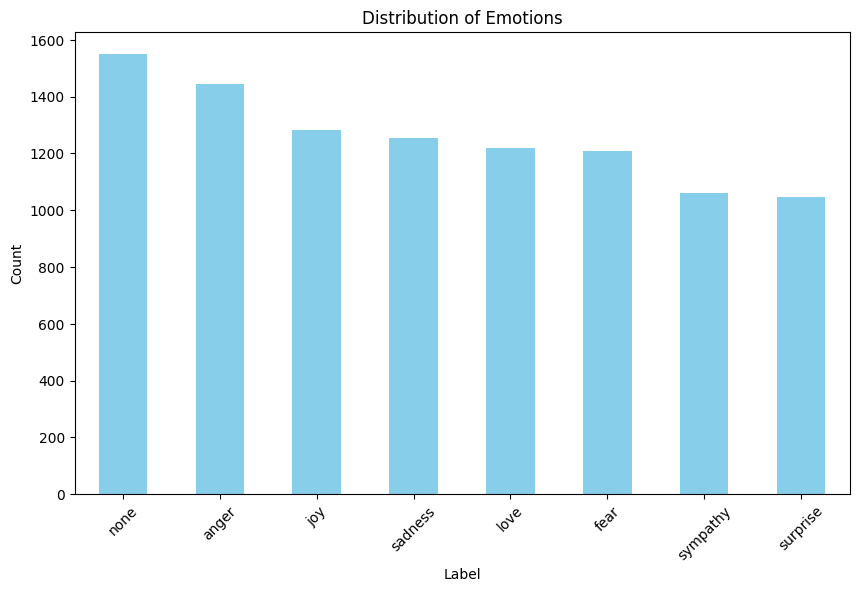

In [12]:
# Count the occurrences of each label
label_counts = df['LABEL'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()

<a id='3'></a>
# <p style="background-color:orange; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;">Word Embedding</p>

In [13]:
# pip install gensim

In [14]:
# ====== N-Grams Models ======

t_model = gensim.models.Word2Vec.load('/kaggle/input/full-grams-300-cbow-twitter/full_grams_cbow_300_twitter.mdl')

In [15]:
token = 'رائع'
if token in t_model.wv:
    most_similar = t_model.wv.most_similar( token, topn=10 )
    for term, score in most_similar:
        term = term.replace(" ", "_")
        if term != token:
            print(term, score)

راائع 0.8284322619438171
جميل_جدا 0.7829281091690063
مميز 0.7392716407775879
رائع_جدا 0.7367711663246155
ممتع 0.7069075703620911
متميز 0.7056905031204224
جميل_ورائع 0.7019288539886475
رايع 0.6941595673561096
راءع 0.680422842502594
جميل 0.6752136945724487


In [16]:
# get a word vector
word_vector = t_model.wv[token]
word_vector

array([ 0.922861  , -0.8140782 ,  0.6061044 , -0.76561314, -1.1395081 ,
        1.7764843 ,  1.9968948 , -1.650122  ,  1.5383117 , -1.9267777 ,
        1.0808858 ,  2.3039765 ,  0.86439747,  0.26068708, -0.80788445,
        0.3509137 ,  0.40684903,  0.3997937 ,  2.543447  ,  0.13541818,
       -0.03665726,  0.04861875, -0.33140895,  0.4194836 , -0.16934334,
        1.75548   , -0.22264321, -0.12063316,  4.124983  ,  0.21049006,
        1.6420494 ,  0.78430074,  0.6087716 ,  0.06169666, -0.33073342,
       -1.053684  ,  0.32370272,  1.0465907 ,  0.20962377,  0.30042386,
       -0.5053498 ,  0.32959294, -1.5044488 , -1.0649966 , -0.6965776 ,
       -0.07228776,  1.6644137 , -1.3177289 ,  1.003004  ,  0.23859487,
       -0.3178939 , -1.2209206 , -0.982392  ,  1.4809748 , -0.8551808 ,
        1.3755822 , -1.7555277 ,  0.04325312,  1.4852753 , -1.3799584 ,
       -0.95226955,  1.5905222 , -0.21297076,  2.4979808 ,  0.38020462,
        2.1501703 , -0.9709928 , -0.8057329 ,  0.71981096, -0.96

<a id='4'></a>
# <p style="background-color:orange; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;">Bi-GRU and Bi-LSTM</p>

### Label Encoding

In [17]:
# Step 1: Create an instance of OneHotEncoder
onehot_encoder = OneHotEncoder()

# Step 2: Fit and transform the data
# Reshape the input to a 2D array, as OneHotEncoder expects a 2D array
labels_encoded = onehot_encoder.fit_transform(df['LABEL'].values.reshape(-1, 1))

# Step 3: Convert the sparse matrix to a dense array and assign column names
encoded_df = pd.DataFrame(labels_encoded.toarray(), columns=onehot_encoder.categories_[0])

# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original 'LABEL' column if needed
df = df.drop(columns=['LABEL'])

# **Get Maximum Sequence Length**

In [18]:
valid_sequences = df['TWEET'].dropna().astype(str)

# Calculate the maximum length
max_sequence_length = max(len(sequence.split()) for sequence in valid_sequences)

# Find the row with the maximum length
max_row = valid_sequences[valid_sequences.apply(lambda x: len(x.split()) == max_sequence_length)].iloc[0]

# Print the result
print("Maximum Sequence Length:", max_sequence_length)
print("Row with Maximum Length:")
print(max_row)

Maximum Sequence Length: 34
Row with Maximum Length:
مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم مش فاهم


**Tokenizer** used tokenize your text data to convert it into a format suitable for input to the neural network.

This typically involves converting words into numerical indices using a tokenizer.

In [19]:
tokenizer = Tokenizer(num_words=32341) # vocab length
tokenizer.fit_on_texts(df['TWEET'].astype('str'))

X = tokenizer.texts_to_sequences(df['TWEET'].astype('str'))

print("vocab size:",len(tokenizer.word_index))

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=300)

vocab_length = len(tokenizer.word_index) + 1
print("Vocablulary Length: ",vocab_length)

vocab size: 32340
Vocablulary Length:  32341


**Saving the Tokenizer for later use**

In [52]:
import json
import os

# Serialize tokenizer configuration to JSON
tokenizer_config = tokenizer.to_json()

# Save the tokenizer configuration to a file in the default Kaggle working directory
file_path = "tokenizer_config.json"  # You can change the filename as needed

with open(file_path, "w") as json_file:
    json_file.write(tokenizer_config)
print("file saved ...")

file saved ...


In [20]:
X.shape[1]

300

In [21]:
X.shape

(10065, 300)

# **Train, Test and  Validation Split**

In [22]:
df.columns

Index(['TWEET', 'anger', 'fear', 'joy', 'love', 'none', 'sadness', 'surprise',
       'sympathy'],
      dtype='object')

In [23]:
# Split the data into 80% training and 20% temp (which will be split into test and validation)
X_train, X_temp, label_train, label_temp = train_test_split(X, encoded_df, test_size=0.2, random_state=42)

# Split the temp data into 50% test and 50% validation
X_test, X_validation, label_test, label_validation = train_test_split(X_temp, label_temp, test_size=0.5, random_state=42)

# Print the lengths of the sets
print("Training:", len(X_train))
print("Testing: ", len(X_test))
print("Validation: ", len(X_validation))


Training: 8052
Testing:  1006
Validation:  1007


In [24]:
num_classes = 8

embedding_matrix = np.zeros((vocab_length, 300))  # Assuming your Word2Vec model has 300-dimensional vectors

for word, i in tokenizer.word_index.items():
    if word in t_model.wv:
        embedding_matrix[i] = t_model.wv[word]

embedding_matrix.shape

(32341, 300)

# **Bi-GRU**

In [25]:
# Shuffle your training data
X_train, label_train = shuffle(X_train, label_train, random_state=42)

# Define early stopping and reduce learning rate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Create your model
Bi_GRU_model = Sequential([
    Embedding(input_dim=vocab_length, output_dim=300, input_length=300, weights=[embedding_matrix]),
    Bidirectional(GRU(units=128, activation='relu', return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(units=128, activation='relu')),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.001)
Bi_GRU_model.compile(optimizer=custom_optimizer, 
              loss='categorical_crossentropy',  # Change the loss function to categorical_crossentropy
              metrics=['accuracy'])

Bi_GRU_model.summary()

# Fit the model using the training data and validate on the validation data
history = Bi_GRU_model.fit(X_train, label_train, epochs=10,
                    validation_data=(X_validation, label_validation),
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          9702300   
                                                                 
 bidirectional (Bidirection  (None, 300, 256)          330240    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 8)                 2

I0000 00:00:1707772159.287914      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/126 [==============================] - 200s 2s/step - loss: 1.2537 - accuracy: 0.5656 - val_loss: 0.9444 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 2/10
126/126 [==============================] - 184s 1s/step - loss: 0.7929 - accuracy: 0.7327 - val_loss: 0.8427 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 3/10
126/126 [==============================] - 184s 1s/step - loss: 0.5855 - accuracy: 0.7988 - val_loss: 0.8720 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 4/10
126/126 [==============================] - 181s 1s/step - loss: 0.3825 - accuracy: 0.8711 - val_loss: 1.0162 - val_accuracy: 0.7001 - lr: 0.0010
Epoch 5/10
126/126 [==============================] - 181s 1s/step - loss: 0.2190 - accuracy: 0.9322 - val_loss: 1.2923 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 6/10
126/126 [==============================] - 179s 1s/step - loss: 0.0882 - accuracy: 0.9734 - val_loss: 1.4771 - val_accuracy: 0.6872 - lr: 2.0000e-04
Epoch 7/10
126/126 [==============================] - 177s 1s/step - lo

In [26]:
# Evaluation for Bi-GRU model
loss_bi_gru, accuracy_bi_gru = Bi_GRU_model.evaluate(X_train, label_train, verbose=True)
print("Bi-GRU Model Training Accuracy: {:.4f}".format(accuracy_bi_gru))
loss_val_bi_gru, accuracy_val_bi_gru = Bi_GRU_model.evaluate(X_test, label_test, verbose=True)
print("Bi-GRU Model Testing Accuracy:  {:.4f}".format(accuracy_val_bi_gru))


252/252 [==============================] - 39s 155ms/step - loss: 0.5477 - accuracy: 0.8296
Bi-GRU Model Training Accuracy: 0.8296
32/32 [==============================] - 5s 155ms/step - loss: 0.8278 - accuracy: 0.7117
Bi-GRU Model Testing Accuracy:  0.7117


**Function for Generating Classification Report for any Model**

In [55]:
def generate_classification_report(model, X_test, label_test):
    """
    Generate a classification report for a given model and test data.
    
    Args:
    - model: The trained model to evaluate.
    - X_test: The input test data.
    - label_test: The true labels of the test data.
    
    Returns:
    - report: The classification report as a string.
    """
    # Define class names
    class_names = ['Anger', 'fear', 'joy','love','None','Sadness' , 'surprise','sympathy' ]

    # Obtain predictions for the test data
    probabilities = model.predict(X_test)
    predictions = np.argmax(probabilities, axis=1)
    
    # Convert one-hot encoded labels back to categorical labels
    label_test_categorical = np.argmax(label_test, axis=1)

    # Generate the classification report
    report = classification_report(label_test_categorical, predictions, target_names=class_names)
    
    return probabilities, report

**Generate classification report for Bi_GRU_model**

In [56]:
# Generate classification report for Bi_GRU_model
bigru_pred, report_bi_gru = generate_classification_report(Bi_GRU_model, X_test, label_test)
print("\nBi-GRU Model Classification Report:")
print(report_bi_gru)

32/32 [==============================] - 5s 153ms/step

Bi-GRU Model Classification Report:
              precision    recall  f1-score   support

       Anger       0.73      0.75      0.74       146
        fear       0.96      0.91      0.93       140
         joy       0.63      0.53      0.58       127
        love       0.80      0.76      0.78       132
        None       0.61      0.90      0.73       135
     Sadness       0.52      0.52      0.52       121
    surprise       0.56      0.35      0.43       109
    sympathy       0.87      0.94      0.90        96

    accuracy                           0.71      1006
   macro avg       0.71      0.71      0.70      1006
weighted avg       0.71      0.71      0.70      1006



# **Bi-LSTM**

In [29]:
Bi_LSTM_model = Sequential()
Bi_LSTM_model.add(layers.Embedding(input_dim=vocab_length, # vocab length
                           output_dim=300, # word embedding dim
                           input_length=300, weights=[embedding_matrix]))
Bi_LSTM_model.add(layers.Bidirectional(layers.LSTM(300, dropout=0.2, 
                                           recurrent_dropout=0.2, 
                                           return_sequences=True)))
Bi_LSTM_model.add(layers.GlobalMaxPool1D())
Bi_LSTM_model.add(layers.Dense(128, activation='relu'))
Bi_LSTM_model.add(layers.Dropout(0.2))
Bi_LSTM_model.add(layers.Dense(64, activation='relu'))
Bi_LSTM_model.add(layers.Dropout(0.2))
Bi_LSTM_model.add(layers.Dense(32, activation='relu'))
Bi_LSTM_model.add(layers.Dropout(0.2))
Bi_LSTM_model.add(layers.Dense(num_classes, activation='softmax'))

Bi_LSTM_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
Bi_LSTM_model.summary()


history = Bi_LSTM_model.fit(X_train, label_train, epochs=4,
                    validation_data=(X_validation, label_validation),
                    batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          9702300   
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 600)          1442400   
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 600)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               76928     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [57]:
# Evaluation for Bi-LSTM model
loss_bi_lstm, accuracy_bi_lstm = Bi_LSTM_model.evaluate(X_train, label_train, verbose=True)
print("Bi-LSTM Model Training Accuracy: {:.4f}".format(accuracy_bi_lstm))
loss_val_bi_lstm, accuracy_val_bi_lstm = Bi_LSTM_model.evaluate(X_test, label_test, verbose=True)
print("Bi-LSTM Model Testing Accuracy:  {:.4f}".format(accuracy_val_bi_lstm))

252/252 [==============================] - 33s 131ms/step - loss: 0.3774 - accuracy: 0.8793
Bi-LSTM Model Training Accuracy: 0.8793
32/32 [==============================] - 4s 131ms/step - loss: 0.9261 - accuracy: 0.7068
Bi-LSTM Model Testing Accuracy:  0.7068


**Generate classification report for Bi_LSTM_model**

In [58]:
# Generate classification report for Bi_LSTM_model
bi_lstm_pred, report_bi_lstm = generate_classification_report(Bi_LSTM_model, X_test, label_test)
print("Bi-LSTM Model Classification Report:")
print(report_bi_lstm)

32/32 [==============================] - 4s 128ms/step
Bi-LSTM Model Classification Report:
              precision    recall  f1-score   support

       Anger       0.69      0.80      0.74       146
        fear       0.93      0.91      0.92       140
         joy       0.65      0.51      0.57       127
        love       0.77      0.72      0.75       132
        None       0.58      0.92      0.71       135
     Sadness       0.53      0.44      0.48       121
    surprise       0.65      0.37      0.47       109
    sympathy       0.88      0.93      0.90        96

    accuracy                           0.71      1006
   macro avg       0.71      0.70      0.69      1006
weighted avg       0.71      0.71      0.70      1006



**Saving models**

In [53]:
Bi_GRU_model.save("BiGRU_model.h5")
print("model saved ...")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model saved ...


In [54]:
Bi_LSTM_model.save("BiLSTM_model.h5")
print("model saved ...")

model saved ...


**Test some random Tweets**

In [61]:
import keras
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_sentiment(tweet, model_path="/kaggle/working/BiGRU_model.h5", max_length=300):
    # Load the saved model
    loaded_model = keras.models.load_model(model_path)
    
    # Preprocess the new tweet
    cleaned_tweet = clean_text(tweet)
    tokenized = tokenizer.texts_to_sequences([cleaned_tweet])
    padded = pad_sequences(tokenized, maxlen=max_length, padding='post')
    
    # Use the model to predict the label for the new tweet
    predictions = loaded_model.predict(padded)
    class_names = ['Anger', 'fear', 'joy','love','None','Sadness' , 'surprise','sympathy' ]
    # Get the predicted label
    predicted_label_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_label_index] if class_names else predicted_label_index
    
    # Print the tweet and predicted label
    print("Tweet:", tweet)
    print("Cleaned Tweet:", cleaned_tweet)
    print("Predicted Label:", predicted_label)

In [61]:
# Example usage
new_tweet ="اانا فرحان اوي  من نتيجة زميلي مجموعه   "
predict_sentiment(new_tweet)

1/1 [==============================] - 1s 657ms/step
Tweet: اانا فرحان اوي  من نتيجة زميلي مجموعه   
Cleaned Tweet: انا فرحان اوي نتيجه زميلي مجموعه
Predicted Label: joy
